In [1]:
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.patches import Rectangle
import seaborn as sns

In [2]:
def parse_dotplot(dotplot_file, name='default'):
    idx_5 = []
    idx_3 = []
    prob = []
    with open(dotplot_file, 'r') as file:
        for line in file:
            parts = line.split()
            # Look for idx_5 idx_3 prob ubox
            # NB: stack probabilities are encoded as idx_5 idx_3 prob lbox
            if len(parts) == 4 and parts[3] == 'ubox':
                x, y, p = int(parts[0]), int(parts[1]), float(parts[2])
                idx_5.append(x)
                idx_3.append(y)
                prob.append(p)
    return pd.DataFrame({'frag':name,'idx_5':idx_5, 'idx_3':idx_3, 'prob_sqrt':prob})

In [3]:
dfs = []
for f in glob.glob('data/*dp.ps'):
    dfs.append(parse_dotplot(f, name=re.search('(\d+)', f).group(0)))
df = pd.concat(dfs)

# Get prob
df['prob'] = df.prob_sqrt ** 2

df['pair'] = df[['idx_5','idx_3']].apply(tuple, axis=1)

# Display parameters:

In [4]:
# dotplots of interest (*.ps):
RNA_1 = '942'
RNA_2 = '993'

# Genomic feature name, coordinates and color:
features = {'TAR':(range(1,58), (0.694,0.488,0.286)),
            'polyA':(range(58,105), (0.0, 0.62, 0.886)),
            'U5':(range(105,116), (0.506, 0.208, 0.541)),
            'PBS':(range(125,224), (0.886, 0.024, 0.075)),
            'DIS':(range(243,278),(0.973, 0.694, 0.2)),
            'MSD':(range(282,301), (0.224, 0.663, 0.208)),
            'Psi':(range(312,326), (0.525, 0.525, 0.525)),
            'ORF':(range(336,2000), plt.cm.Set3.colors[6])}

# Plot limits:
min_idx_x = 0
min_idx_y = 0
max_idx_x = 993
max_idx_y = 942

# Scatterplot specs:
scatterprops = dict(
    linewidth=0, size='prob_sqrt', size_norm=(0,1), hue='prob',
    hue_norm=(0,1), palette='binary', marker='.', sizes=(0,50)
)

# Colormap style
cmap = 'Greys'

# Annotation specs
rect_props = {'ls':'--', 'color':'magenta', 'lw':1, 'fill':False, 'clip_on':False}
annot_width = 20 # Rectangle width
annot_spacing = 5 # Spacing from the plot
lineprops = {'ls':':', 'color':'.5', 'lw':1} # lines to highlight feature limits

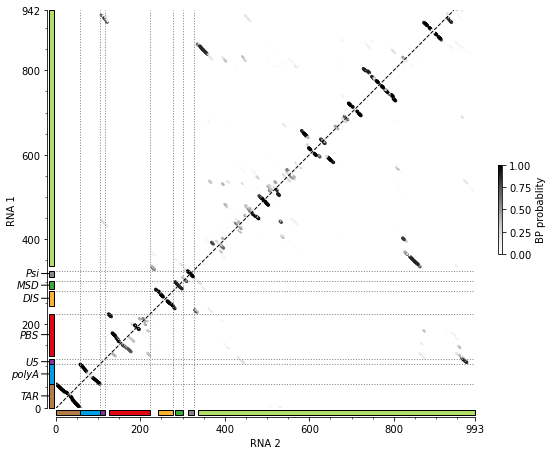

In [5]:
fig, ax = plt.subplots(figsize=(8,8))

# Draw doplots
sns.scatterplot(data=df.loc[df.frag==RNA_1].groupby(['idx_5','idx_3']).median(),
                y='idx_3', x='idx_5', label='Cluster 1', ax=ax, **scatterprops)
sns.scatterplot(data=df.loc[df.frag==RNA_2].groupby(['idx_5','idx_3']).median(),
                y='idx_5', x='idx_3', label='Cluster 2', ax=ax, **scatterprops)

# Create a colorbar for the probabilities:
norm = plt.Normalize(0,1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, label='BP probablity', fraction=.01)

# Remove legend
ax.legend().set_visible(False)

#Add diag
ax.axline((0,0), slope=1,  color='0.0', linewidth=1, ls='--')

#Shift left and bottom spines
ax.set_yticks([i for i in range(0,max_idx_y,200)] + [max_idx_y])
ax.set_xticks([i for i in range(0,max_idx_x,200)] + [max_idx_x])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('data',-annot_width))
ax.spines['bottom'].set_position(('data',-annot_width))
ax.set_ylim((min_idx_y, max_idx_y))
ax.set_xlim((min_idx_x, max_idx_x))
ax.set_aspect(1)
ax.set_ylabel('RNA 1')
ax.set_xlabel('RNA 2')


# Highlight regions of interest

#Add line annotation
for f in features:
    ax.axvline(x=features[f][0].stop, **lineprops)
    ax.axhline(y=features[f][0].stop, **lineprops)

# Add sequence annotations
for f in features:
    # vertically
    box = Rectangle(
        (-annot_width + annot_spacing, features[f][0].start),
        annot_width - 2 * annot_spacing,
        np.clip(features[f][0].stop - features[f][0].start, 0, ax.get_ylim()[1] - features[f][0].start),
        fill=True, color=features[f][1], clip_on=False, lw=1, ec='0.0'
    )
    ax.add_patch(box)
    
    # then horizontally
    box = Rectangle(
        (features[f][0].start, -annot_width + annot_spacing),
        np.clip(features[f][0].stop - features[f][0].start, 0, ax.get_xlim()[1] - features[f][0].start),
        annot_width - 2 * annot_spacing,
        fill=True, color=features[f][1], clip_on=False, lw=1, ec='0.0'
    )
    ax.add_patch(box)
    
    # Add labels (only vertically)
    xpos = -annot_width + annot_spacing
    ypos = features[f][0].start + (features[f][0].stop - features[f][0].start) / 2
    if min_idx_y < ypos < max_idx_y:
        ax.annotate(
            f, (xpos, ypos),
            xytext=(-10,0), textcoords='offset points', ha='right', va='center',
            arrowprops={'arrowstyle':'-', 'shrinkA':0, 'shrinkB':0},
            annotation_clip=False, fontstyle='italic'
        )

ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(50))

plt.savefig('./images/RNAfoldDotPlot.png', bbox_inches='tight')